# Jaguar Movement Databse

## Investigating Jaguar Behavior in Relation to Meteorological Conditions

This project aims to document, analyze and model jaguar movement patterns (Panthera Onca) from geo-referenced data of South and Central America and understanding how environmental factors influence their movement ecology. The main steps done are the preprocessing, to ensure data quality, consistency and usability to apply Machine Learning tasks.
By taking advantage of a multi-year meteorological dataset, for five countries (Brazil, Paraguay, Argentina, Costa Rica, and Mexico), this project integrates the GPS data of several individual jaguars with said meteorlogical records.

## Motivation

Jaguars, as apex predators, play a critical role in ecosystem balance, but their movements remain poorly understood in the context of climate-driven habitat changes. Extreme weather events and shifting precipitation patterns threaten their habitats, making it imperative to identify how environmental conditions modulate behaviors such as hunting, territorial patrolling, and resting.

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from geopy.distance import geodesic
import sqlite3


In [176]:
SAMPLE_SIZE = 20000

# Load dataset
data = pd.read_csv('H:/Study/IPCA/MIAA/MLA/TP2025/DataS1/jaguar_movement_data.csv')
conn = sqlite3.connect('jaguar_data.db')

# data = data.sample(SAMPLE_SIZE) 

data.head()

C:\Users\Guima\AppData\Local\Temp\ipykernel_11620\961086142.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('H:/Study/IPCA/MIAA/MLA/TP2025/DataS1/jaguar_movement_data.csv')


,Event_ID,timestamp,location.long,location.lat,individual.taxon.canonical.name,tag.local.identifier,individual.local.identifier (ID),study.name,country
0,1.0,6/15/10 22:43,-58.030128,-23.326947,Panthera onca,0-333005,1,Humid Chaco,Paraguay
1,2.0,6/16/10 2:52,-58.030643,-23.328427,Panthera onca,0-333005,1,Humid Chaco,Paraguay
2,3.0,6/16/10 22:36,-58.030472,-23.327311,Panthera onca,0-333005,1,Humid Chaco,Paraguay
3,4.0,6/17/10 16:42,-58.027983,-23.309952,Panthera onca,0-333005,1,Humid Chaco,Paraguay
4,5.0,6/17/10 20:37,-58.027747,-23.310006,Panthera onca,0-333005,1,Humid Chaco,Paraguay


In [177]:
data_cp = data.copy()
data_cp.isnull().sum()

Event_ID                            0
timestamp                           0
location.long                       0
location.lat                        0
individual.taxon.canonical.name     0
tag.local.identifier                0
individual.local.identifier (ID)    0
study.name                          0
country                             0
dtype: int64

## Fixing features names

In [178]:
# Fix features names Event_ID,timestamp,location.long,location.lat,individual.taxon.canonical.name,tag.local.identifier,individual.local.identifier (ID),study.name,country
data_cp = data_cp.rename(columns={'Event_ID':'event_id','timestamp':'timestamp','location.long':'location_long','location.lat':'location_lat','individual.taxon.canonical.name':'individual_taxon_canonical_name','tag.local.identifier':'tag_local_identifier','individual.local.identifier (ID)':'individual_local_identifier_ID','study.name':'study_name','country':'country'})

# Print features names
data_cp.columns


Index(['event_id', 'timestamp', 'location_long', 'location_lat',
       'individual_taxon_canonical_name', 'tag_local_identifier',
       'individual_local_identifier_ID', 'study_name', 'country'],
      dtype='object')

# Preprocess timestamp

In [179]:
# Parsing the timestamp column into a datetime format
data_cp['timestamp'] = pd.to_datetime(data_cp['timestamp'])

# Extract time of day, day of the week, month, etc., for temporal features.
data_cp['hour'] = data_cp['timestamp'].dt.hour
data_cp['day'] = data_cp['timestamp'].dt.day
data_cp['month'] = data_cp['timestamp'].dt.month
data_cp['year'] = data_cp['timestamp'].dt.year
data_cp['dayofweek'] = data_cp['timestamp'].dt.dayofweek
data_cp['date'] = data_cp['timestamp'].dt.date

# Show unique values for day, month and year
# print(data_cp['day'].unique())
# print(data_cp['month'].unique())
# print(data_cp['year'].unique())
# print(data_cp['country'].unique())

C:\Users\Guima\AppData\Local\Temp\ipykernel_11620\3021486648.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_cp['timestamp'] = pd.to_datetime(data_cp['timestamp'])


In [180]:
# data_cp = data_cp.drop(['event_id', 'individual_local_identifier_ID', 'tag_local_identifier'], axis=1)

data_cp.columns

Index(['event_id', 'timestamp', 'location_long', 'location_lat',
       'individual_taxon_canonical_name', 'tag_local_identifier',
       'individual_local_identifier_ID', 'study_name', 'country', 'hour',
       'day', 'month', 'year', 'dayofweek', 'date'],
      dtype='object')

# Geospatial Data Processing

Calculating the distance between points using the Haversine Formula and group the data by tag_local_identifier to quantify travel distances and velocities. 
Engineered behavioral labels (hunting, movement, stopped) based on velocity thresholds.

The top speed for a big cat (Jaguar) was considered to be of 50 mph or 80km/h for the labeling.

Using the haversine formula, we were able to determine the distance between the coordinates along the Earth's surface.
Although, since the Earth is not perfectly round, this formula may have an error up to 0.5%.

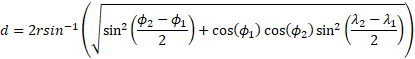

In [181]:
data_fe = data_cp.copy()

data_fe['timestamp'] = pd.to_datetime(data_fe['timestamp'])

# Define Haversine formula for distance calculation
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

# Function to calculate distance only for the same animal
def calculate_distances_for_animal(group):
    group = group.sort_values('timestamp')
    group['distance'] = haversine(
        group['location_lat'].shift(),
        group['location_long'].shift(),
        group['location_lat'],
        group['location_long']
    )
    return group

data_fe = data_fe.groupby('tag_local_identifier').apply(calculate_distances_for_animal)

# Convert distance to kilometers
data_fe['distance'] = data_fe['distance'] / 1000
data_fe['distance'] = data_fe['distance'].round(4)

data_fe.head()

C:\Users\Guima\AppData\Local\Temp\ipykernel_11620\635299427.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_fe = data_fe.groupby('tag_local_identifier').apply(calculate_distances_for_animal)


event_id           timestamp  location_long  \
tag_local_identifier                                                       
35957                131870  131871.0 2015-10-12 00:00:00     -57.503400   
                     131871  131872.0 2015-10-12 01:00:00     -57.503355   
                     131872  131873.0 2015-10-12 02:01:00     -57.503327   
                     131873  131874.0 2015-10-12 03:00:00     -57.503302   
                     131874  131875.0 2015-10-12 04:00:00     -57.503297   

                             location_lat individual_taxon_canonical_name  \
tag_local_identifier                                                        
35957                131870    -16.881275                   Panthera onca   
                     131871    -16.881304                   Panthera onca   
                     131872    -16.881216                   Panthera onca   
                     131873    -16.881220                   Panthera onca   
                     131874    -16.881144                   Panthera onca   

                            tag_local_identifier  \
tag_local_identifier                               
35957                131870                35957   
                     131871                35957   
                     131872                35957   
                     131873                35957   
                     131874                35957   

                             individual_local_identifier_ID     study_name  \
tag_local_identifier                                                         
35957                131870                             117  Jaguar_Taiama   
                     131871                             117  Jaguar_Taiama   
                     131872                             117  Jaguar_Taiama   
                     131873                             117  Jaguar_Taiama   
                     131874                             117  Jaguar_Taiama   

                            country  hour  day  month  year  dayofweek  \
tag_local_identifier                                                     
35957                131870  Brazil     0   12     10  2015          0   
                     131871  Brazil     1   12     10  2015          0   
                     131872  Brazil     2   12     10  2015          0   
                     131873  Brazil     3   12     10  2015          0   
                     131874  Brazil     4   12     10  2015          0   

                                   date  distance  
tag_local_identifier                               
35957                131870  2015-10-12       NaN  
                     131871  2015-10-12    0.0058  
                     131872  2015-10-12    0.0102  
                     131873  2015-10-12    0.0026  
                     131874  2015-10-12    0.0084

# Creating velocity, direction, and movement features based on location data (location.long, location.lat).

Labelling the movement based on the distance and velocity between each coordinates let's us determine what kind of behaviour our big cats were having. These were labelled as (movement, hunting, resting). To calculate the velocity, the difference between each timestamp in hours was extracted and measure the distance between each timestamp to kilometers. Based on the results we could argue that, since the jaguars are captivity inside reservations, there could not be much hunting activity since they would be fed by humans.

velocity = distance / time

Example: 1.5578(kilometers) / 60.033333 (hours) = 0.0259489 km/h

movement > 0.5: 'hunting' (highest priority)

0.1 < velocity ≤ 0.5: 'movement'

= 0.0 'stopped'

< 0.0: 'movement'

In [182]:
# Creating velocity, direction, and movement features based on location data (location.long, location.lat).
# Ensuring the time differece is i hours
time_diff = data_fe['time_diff'] = data_fe['timestamp'].diff().dt.total_seconds() / 3600 # hours

# print(data_fe.head())

In [183]:
# Ensure the time difference is in hours
data_fe['time_diff'] = data_fe['timestamp'].diff().dt.total_seconds() / 3600

# Calculate velocity
data_fe['velocity'] = data_fe['distance'] / data_fe['time_diff']

print(data_fe[['distance', 'time_diff', 'velocity']].sample(5))

                             distance  time_diff  velocity
tag_local_identifier                                      
1494                 116327    0.0007   2.000000  0.000350
36313                47208     0.0083   1.000000  0.008300
                     46731     0.0224   1.016667  0.022033
31936                23317     0.8918   0.500000  1.783600
No5                  79671     0.7909   3.983333  0.198552


In [184]:
JAGUAR_SPEEDS = {
    'resting': (0, 1),
    'slow_movement': (1, 10),
    'patrolling': (10, 30),
    'hunting': (30, 80)
}

data_fe['movement'] = np.select(
    [
        data_fe['velocity'].between(*JAGUAR_SPEEDS['resting']),
        data_fe['velocity'].between(*JAGUAR_SPEEDS['slow_movement']),
        data_fe['velocity'].between(*JAGUAR_SPEEDS['patrolling']),
        data_fe['velocity'].between(*JAGUAR_SPEEDS['hunting'])
    ],
    [
        'resting',
        'slow_movement',
        'patrolling',
        'hunting'
    ],
    default='unknown'
)

data_fe = data_fe.dropna(subset=['distance', 'velocity'])
data_fe['velocity'] = data_fe['velocity'].round(2)

print(data_fe['movement'].value_counts())

data_fe['direction'] = np.arctan2(data_fe['location_long'] - data_fe['location_long'].shift(), data_fe['location_lat'] - data_fe['location_lat'].shift())

movement
resting          128189
slow_movement      6373
patrolling           14
hunting               1
Name: count, dtype: int64


## Deriving acceleration or changes in movement direction.

In [185]:
# Calculate acceleration as the change in velocity over time
data_fe['acceleration'] = data_fe['velocity'].diff() / data_fe['time_diff']

# Calculate change in direction
data_fe['change_in_direction'] = data_fe['direction'].diff()

# Drop rows with NaN values in acceleration and change_in_direction
data_fe = data_fe.dropna(subset=['acceleration', 'change_in_direction'])

# Round the values for better readability
data_fe['acceleration'] = data_fe['acceleration'].round(4)
data_fe['change_in_direction'] = data_fe['change_in_direction'].round(4)

# Display the first few rows of the updated dataframe
data_fe[['acceleration', 'change_in_direction']].head()
data_fe.to_csv('H:/Study/IPCA/MIAA/MLA/TP2025/DataS1/jaguar_movement_data_cleaned.csv', index=False)

## Encoding Categorical Variables

In [186]:
# Encode tag_local_identifier to numerical values

data_fe['tag_local_identifier'] = pd.Categorical(data_fe['tag_local_identifier'])
data_fe['tag_local_identifier'] = data_fe['tag_local_identifier'].cat.codes

print(data_fe['tag_local_identifier'].unique())
# data_encoded = pd.get_dummies(data_fe, columns=['tag_local_identifier'])
# data_encoded.columns
# data_encoded['tag_local_identifier'].unique()

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112]


## Now we want to get temporal features from Paraguay, Brazil, Costa Rica, Argentina and Mexico between 1/1/1999 and 31/12/2016

In [187]:
# Get World  Climate data
import kagglehub

path = kagglehub.dataset_download("christopherlemke/monthly-climat-reports-from-stations-worldwide")

reports_data = pd.read_csv(path + '/dwd-cdc_CLIMAT_reports_stations_ww.csv')
stations_data = pd.read_csv(path + '/dwd-cdc_station_data_ww.csv')

# Save the data to a csv file
reports_data.to_csv('H:/Study/IPCA/MIAA/MLA/TP2025/DataS1/monthly-climat-reports-from-stations-worldwide.csv', index=False)
stations_data.to_csv('H:/Study/IPCA/MIAA/MLA/TP2025/DataS1/dwd-cdc_station_data_ww.csv', index=False)

print(reports_data.shape)
print(stations_data.shape)

reports_data = reports_data.sample(SAMPLE_SIZE)
# stations_data = stations_data.sample(SAMPLE_SIZE)

# print(reports_data.head())
# print(stations_data.head())

# print("Path to dataset files:", path)

(553652, 127)
(4169, 6)


### Preprocessing Reports data

In [188]:
def farenheit_to_celsius(farenheit):
    return ((farenheit - 32) * 5.0)/9.0

Integration of meteorological data such as temperature and rainfall. The temperature would be converted from Farenheit to Celsius, though the precipitation remains as mm.


In [189]:
# Remove columns
reports_data_dropped = reports_data.drop(['Po', 'Po.1', 'P', 'P.1', 'T.1', 'st', 'st.1', 
                                          'Tx.1', 'Tn.1', 
                                          'e', 'e.1', 
                                          'R1.1', 'nr.1', 'S1.1', 'Rd', 'mp', 'mT', 'mTx', 'mTn', 'me', 'mR', 'mS', 
                                            #   'sn', 'sn.1', 'sn.2', 'sn.3', 'sn.4', 'sn.5', 'sn.6', 'sn.7', 'sn.8', 'sn.9',
                                            # 'G1', 'G1.1', 'G1.2', 'G1.3', 'G1.4', 'G1.5', 'G1.6', 'G1.7', 'G1.8',
                                            # 'G2', 'G2.1', 'G2.2', 'G2.3', 'G2.4', 'G2.5', 'G2.6', 'G2.7', 'G2.8', 'G2.9',
                                            # 'G3', 'G3.1', 'G3.2', 'G3.3', 'G3.4', 'G3.5', 'G3.6', 'G3.7', 'G3.8', 'G3.9',
                                            # 'G4', 'G4.1', 'G4.2', 'G4.3', 'G4.4', 'G4.5', 'G4.6', 'G4.7',
                                            'Yb', 'Yc', 'P', 'YP', 'YR', 'YS', 'YT', 'YTx',
                                            'Ye', 'G4', 'Txd', 'yx', 'Tnd', 'Tax', 'Tan' ], axis=1)

# Drop columns with no data
reports_data_dropped = reports_data_dropped.dropna(axis=1, how='all')

# Rename columns
reports_data_renamed = reports_data_dropped.rename(columns={'IIiii':'station_id', 'T':'monthly_mean_air_temperature', 
                                            'Tx':'mean_daily_maximum_air_temperature', 
                                            'Tn':'mean_daily_minimum_air_temperature', 
                                            'R1':'total_precipitation_month', 'S1':'total_sunshine_month', 
                                            'ps':'percentage_total_sunshine_duration_relative_normal', 
                                            'P0':'monthly_mean_pressure_station_level', 'e':'mean_vapor_pressure_month', 
                                            'nr':'number_days_month_precipitation', 
                                            'yP':'missing_years_air_pressure', 'yR':'missing_years_precipitation', 'yS':'missing_years_sunshine_duration', 
                                            'yT':'missing_years_mean_air_temperature', 'yTx':'missing_years_mean_extreme_air_temperature', 'ye':'missing_years_vapor_pressure', 
                                            'T25':'days_month_maximum_air_temperature_25', 'T30':'days_month_maximum_air_temperature_30', 
                                            'T35':'days_month_maximum_air_temperature_35', 'T40':'days_month_maximum_air_temperature_40', 
                                            'Tn0':'days_month_minimum_air_temperature_0', 'Tx0':'days_month_maximum_air_temperature_0', 'R01':'days_month_precipitation_1', 
                                            'R05':'days_month_precipitation_5', 'R10':'days_month_precipitation_10', 'R50':'days_month_precipitation_50', 
                                            'R100':'days_month_precipitation_100', 'R150':'days_month_precipitation_150', 's00':'days_month_snow_depth_0', 
                                            's01':'days_month_snow_depth_1', 's10':'days_month_snow_depth_10', 's50':'days_month_snow_depth_50', 'f10':'days_month_wind_speed_10', 
                                            'f20':'days_month_wind_speed_20', 'f30':'days_month_wind_speed_30', 'V1':'days_month_visibility_50', 'V2':'days_month_visibility_100', 
                                            'V3':'days_month_visibility_1000', 'yn': 'day_lowest_daily_mean_air_temperature_month', 'yax': 'day_highest_daily_mean_air_temperature_month', 'yan':'day_lowest_air_tempreature_month',
                                            'Rx':'highest_daily_amount_precipitation_month_tenths_mm',  
                                            # 'yr':'day_highest_daily_amount_precipitation_month'
                                            })

# Remove rows with missing values in [year]
reports_data_renamed = reports_data_renamed.dropna(subset=['year'])

# Enconde Year, Month, and Station ID to integer
reports_data_renamed['year'] = reports_data_renamed['year'].apply(lambda x: int(x) if pd.notnull(x) else x)
reports_data_renamed['month'] = reports_data_renamed['month'].apply(lambda x: int(x) if pd.notnull(x) else x)
reports_data_renamed['station_id'] = reports_data_renamed['station_id'].apply(lambda x: int(x) if pd.notnull(x) else x)
reports_data_renamed['sn'] = reports_data_renamed['sn'].apply(lambda x: int(x) if pd.notnull(x) else x)

# print(reports_data_renamed[['mean_daily_maximum_air_temperature']].head())

# Convert temperature features to Celsius
# °C = (°F - 32) × 5/9
reports_data_renamed['monthly_mean_air_temperature'] = farenheit_to_celsius(reports_data_renamed['monthly_mean_air_temperature']).round(2)
reports_data_renamed['mean_daily_maximum_air_temperature'] =  farenheit_to_celsius(reports_data_renamed['mean_daily_maximum_air_temperature']).round(2)
reports_data_renamed['mean_daily_minimum_air_temperature'] = farenheit_to_celsius(reports_data_renamed['mean_daily_minimum_air_temperature']).round(2)

# print(reports_data_renamed[['mean_daily_maximum_air_temperature']].head())

# Check for missing values in temperature features
# print(reports_data_renamed[['monthly_mean_air_temperature', 'mean_daily_maximum_air_temperature', 'mean_daily_minimum_air_temperature']].isnull().sum())

# Fill missing values with the mean
reports_data_renamed['monthly_mean_air_temperature'] = reports_data_renamed['monthly_mean_air_temperature'].fillna(reports_data_renamed['monthly_mean_air_temperature'].mean())
reports_data_renamed['mean_daily_maximum_air_temperature'] = reports_data_renamed['mean_daily_maximum_air_temperature'].fillna(reports_data_renamed['mean_daily_maximum_air_temperature'].mean())
reports_data_renamed['mean_daily_minimum_air_temperature'] = reports_data_renamed['mean_daily_minimum_air_temperature'].fillna(reports_data_renamed['mean_daily_minimum_air_temperature'].mean())

print(reports_data_renamed[['highest_daily_amount_precipitation_month_tenths_mm', 'mean_daily_maximum_air_temperature', 'mean_daily_minimum_air_temperature']].isnull().sum())

# Show null values
# print(reports_data_renamed.isnull().sum())
reports_data_renamed.to_csv('H:/Study/IPCA/MIAA/MLA/TP2025/DataS1/monthly-climat-reports-from-stations-worldwide-cleaned.csv', index=False)

reports_data_renamed.head()


highest_daily_amount_precipitation_month_tenths_mm    6032
mean_daily_maximum_air_temperature                       0
mean_daily_minimum_air_temperature                       0
dtype: int64


,year,month,station_id,G1,G1.1,G1.2,sn,monthly_mean_air_temperature,G1.3,sn.1,...,iw,fx,yfx,G4.6,Dts,Dgr,G4.7,iy,Gx,Gn
174125,2010,5,7020,1.0,2.0,3.0,0.0,42.78,4.0,0.0,...,1.0,190.0,29.0,NaN,NaN,NaN,7.0,2.0,6.0,18.0
451173,2020,3,30844,1.0,2.0,3.0,1.0,17.78,4.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164920,2014,1,71261,1.0,2.0,3.0,1.0,27.22,4.0,1.0,...,4.0,45.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
429291,2007,12,85289,1.0,2.0,3.0,0.0,136.11,4.0,0.0,...,4.0,18.0,11.0,NaN,NaN,NaN,7.0,1.0,21.0,12.0
336933,2018,10,72514,1.0,2.0,3.0,0.0,51.67,4.0,0.0,...,NaN,NaN,NaN,6.0,1.0,0.0,NaN,NaN,NaN,NaN


In [190]:
# stations_data.dtypes

# Rename columns
# 0: Station ID, 1: Station Name, 2: Latitude, 3: Longitude, 4:Height, 5: Country
stations_data_renamed = stations_data.rename(columns={'0':'station_id', '1':'station_name', '2':'latitude', '3':'longitude', '4':'height', '5':'country'})
stations_data_renamed['station_id'] = stations_data_renamed['station_id'].str.strip()
stations_data_renamed = stations_data_renamed[:-1]

print(stations_data_renamed['station_id'].unique())


stations_data_renamed['station_id'] = (
    stations_data_renamed['station_id']
    .str.replace(r'\D', '', regex=True)  # Remove all non-digit characters
    .pipe(pd.to_numeric, errors='coerce')  # Convert to numeric, invalid become NaN
    .astype('Int64')  # Convert to pandas' nullable Int64 type
)

['01001' '01005' '01007' ... '99090' '99092' '99113']


In [191]:
# Merge the reports and stations data by station_id
import sqlite3

data_merged = pd.merge(reports_data_renamed, stations_data_renamed, on='station_id')

# data_fe['country'].unique()

print(data_merged['highest_daily_amount_precipitation_month_tenths_mm'])

data_merged['country'] = data_merged['country'].str.strip()
# print(data_merged.columns)

# print(data_merged['country'].unique())

# data_merged['country'].isnull().sum()

# print(data_merged.columns)

month_daily_data = data_merged[['year', 'month', 'station_id', 'country', 'mean_daily_maximum_air_temperature', 'mean_daily_minimum_air_temperature', 'total_precipitation_month', 
'number_days_month_precipitation', 'total_sunshine_month', 'percentage_total_sunshine_duration_relative_normal', 'days_month_maximum_air_temperature_25', 
'days_month_maximum_air_temperature_30', 'days_month_maximum_air_temperature_35', 'days_month_maximum_air_temperature_40', 'days_month_minimum_air_temperature_0', 
'days_month_maximum_air_temperature_0', 'days_month_precipitation_1', 'days_month_precipitation_5', 'days_month_precipitation_10', 'days_month_precipitation_50', 
'days_month_precipitation_100', 'days_month_precipitation_150', 'days_month_snow_depth_0', 'days_month_snow_depth_1', 'days_month_snow_depth_10', 'days_month_snow_depth_50', 
'days_month_visibility_50', 'days_month_visibility_100', 'days_month_visibility_1000', 'day_lowest_air_tempreature_month', 'day_highest_daily_mean_air_temperature_month', 'day_lowest_air_tempreature_month', 
'highest_daily_amount_precipitation_month_tenths_mm']]

# print(data_fe.shape)

# print(month_daily_data.head())

# data_merged.head()

conn = sqlite3.connect('jaguar_data.db')

# Save data to SQLite database
reports_data_renamed.to_sql('reports', conn, if_exists='replace', index=False)
stations_data_renamed.to_sql('stations', conn, if_exists='replace', index=False)
# data_merged.to_sql('reports_country', conn, if_exists='replace', index=False)
data_fe.to_sql('data_fe', conn, if_exists='replace', index=False)

print("=== REPORTS DATA ===")
print(reports_data_renamed.head())

print("=== STATIONS DATA ===")
print(stations_data_renamed.head())

print("=== DATA FE ===")
print(data_fe.head())

print("Data successfully loaded into SQLite database!")

conn.close()

# Merge data_merged with data_fe only by the countries and date in data_fe
# data_merged_countries = pd.merge(data_fe, month_daily_data, on=['country', 'year', 'month'], how='inner')

# data_merged_countries = pd.merge(data_merged, data_fe, on='country', how='inner')
# data_merged_countries = data_merged[data_merged['country'].isin(data_fe['country'].unique())]
# data_merged_countries.head()

# print(reports_data_renamed['highest_daily_amount_precipitation_month_tenths_mm'])

# 1. Merge reports and stations
data_merged = pd.merge(
    reports_data_renamed,
    stations_data_renamed,
    on='station_id'
)

print("=== DATA MERGED ===")
print(data_merged.head())

# print(data_merged['highest_daily_amount_precipitation_month_tenths_mm'])

# 2. Clean and rename columns
data_merged['country'] = data_merged['country'].str.strip()
data_merged = data_merged.rename(columns={
    'year_x': 'year',
    'month_x': 'month'
})

# 3. Aggregate to country-month level
country_month_climate = (
    data_merged
    .groupby(['country', 'year', 'month'])
    .agg({
        'mean_daily_maximum_air_temperature': 'mean',
        'mean_daily_minimum_air_temperature': 'mean',
        'total_precipitation_month': 'sum',
        'highest_daily_amount_precipitation_month_tenths_mm': 'mean',
        'number_days_month_precipitation': 'max'
    })
    .reset_index()
)

data_fe = data_fe.rename(columns={
    'year_x': 'year',
    'month_x': 'month'
})

# 4. Merge with movement data
data_merged_countries = pd.merge(
    data_fe,
    country_month_climate,
    on=['country', 'year', 'month'],
    how='inner'
)

print("Database connection closed.")

print("=== DATA MERGED COUNTRIES ===")
print(data_merged_countries.head())

# Save
data_merged_countries.to_csv('H:/Study/IPCA/MIAA/MLA/TP2025/DataS1/jaguar_movement_with_countries_climate_data.csv', index=False)

0         26.0
1          NaN
2        158.0
3        967.0
4        284.0
         ...  
18716      NaN
18717      1.0
18718    144.0
18719     74.0
18720    325.0
Name: highest_daily_amount_precipitation_month_tenths_mm, Length: 18721, dtype: float64
=== REPORTS DATA ===
        year  month  station_id   G1  G1.1  G1.2   sn  \
174125  2010      5        7020  1.0   2.0   3.0  0.0   
451173  2020      3       30844  1.0   2.0   3.0  1.0   
164920  2014      1       71261  1.0   2.0   3.0  1.0   
429291  2007     12       85289  1.0   2.0   3.0  0.0   
336933  2018     10       72514  1.0   2.0   3.0  0.0   

        monthly_mean_air_temperature  G1.3  sn.1  ...   iw     fx   yfx  G4.6  \
174125                         42.78   4.0   0.0  ...  1.0  190.0  29.0   NaN   
451173                         17.78   4.0   0.0  ...  NaN    NaN   NaN   NaN   
164920                         27.22   4.0   1.0  ...  4.0   45.0   6.0   NaN   
429291                        136.11   4.0   0.0  ...  4.0 